In [1]:
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import rc
from matplotlib.ticker import FixedLocator
import os.path as osp
import os
import cartopy.crs as ccrs
import geopandas as gpd
import geoplot as gplt
import geoplot.crs as gcrs
from shapely.geometry import Point, LineString, Polygon
from shapely import geometry
from cartopy.feature import ShapelyFeature
import networkx as nx
import itertools as it
from PIL import ImageColor

### Define settings for plotting

In [217]:
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"],
    "font.size": 12})

xspacing = FixedLocator([0, 5, 10, 15, 20])
yspacing = FixedLocator([45, 50, 55])

dpi = 300

c_radar_loc = '#cc3300'
c_radar_area = '#347B98'
c_boundary = '#092834'
c_boundary_light = '#0a3142'
c_text = '#262626'
c_countries = 'lightgray'

### Load all relevant data

In [2]:
root = '/home/fiona/birdMigration'
# root = '/media/fiona/Seagate Basic/PhD/paper_1/'
target_dir = osp.join(root, 'data/plots/final')
os.makedirs(target_dir, exist_ok=True)

voronoi = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi = voronoi.to_crs(epsg=4326)

voronoi_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/voronoi.shp'))
voronoi_b = voronoi_b.to_crs(epsg=4326)

delaunay_b = nx.read_gpickle(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/delaunay.gpickle'))

radar_buffers = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars = radar_buffers.centroid.to_crs(epsg=4326)
radar_buffers = radar_buffers.to_crs(epsg=4326)

radar_buffers_b = gpd.read_file(osp.join(root, 'data/preprocessed/1H/voronoi_dummy_radars=15_exclude=[]/radar/fall/2015/radar_buffers.shp'))
radars_b = radar_buffers_b.centroid.to_crs(epsg=4326)

countries = gpd.read_file(osp.join(root, 'data/shapes/ne_10m_admin_0_countries_lakes.shp'))

extent = voronoi_b.total_bounds
extent[1] -= 0.5
crs = ccrs.AlbersEqualArea(central_longitude=voronoi.lon.mean(), central_latitude=voronoi.lat.mean())

DriverError: /home/fiona/birdMigration/data/preprocessed/1H/voronoi_dummy_radars=0_exclude=[]/radar/fall/2015/voronoi.shp: No such file or directory

### Radar locations & VP range

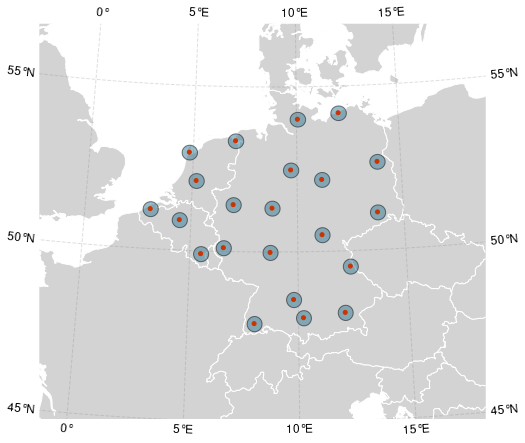

In [232]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)
gplt.polyplot(radar_buffers, ax=ax, 
              facecolor=c_radar_area, alpha=0.5, extent=extent, zorder=1)
gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join(target_dir, 'radar_locations.png'), bbox_inches='tight', dpi=dpi)

### Voronoi tessellation with boundary cells

In [214]:
voronoi_b.query('boundary == 1').index

Int64Index([22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36], dtype='int64')

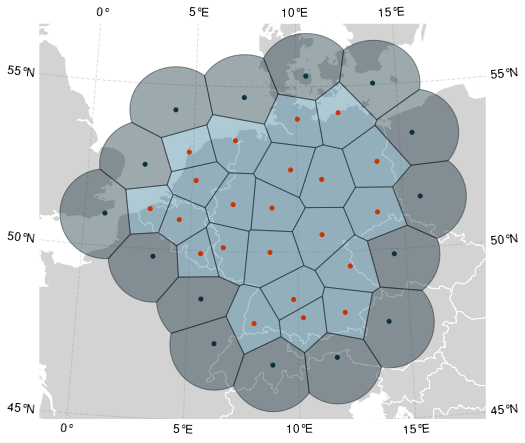

In [218]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)
gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.4, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, facecolor=c_radar_area, alpha=0.4, extent=extent, zorder=2)
gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)
gplt.pointplot(radars_b[voronoi_b.query('boundary == 1').index], ax=ax, extent=extent, zorder=3, color=c_boundary_light, s=4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join(target_dir, 'voronoi_tessellation.png'), bbox_inches='tight', dpi=dpi)

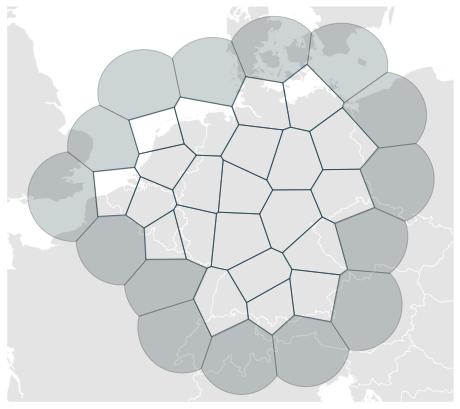

In [250]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0, alpha=0.6)
gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.2, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, edgecolor=c_boundary_light, alpha=0.6, extent=extent, zorder=2)

fig.savefig(osp.join(target_dir, 'voronoi_tessellation_background.png'), bbox_inches='tight', dpi=dpi)

### Voronoi cells with radar names

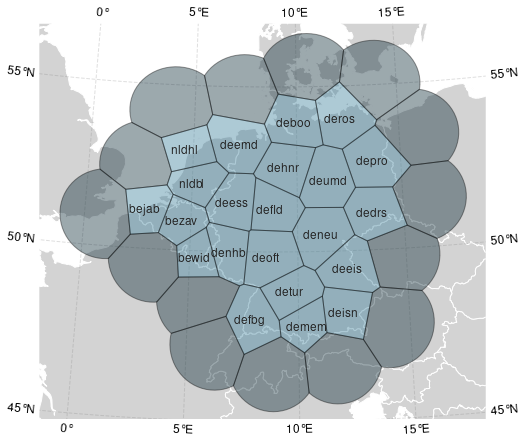

In [158]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

gplt.polyplot(voronoi_b.query('boundary == 1'), ax=ax, facecolor=c_boundary, alpha=0.4, extent=extent, zorder=2)
gplt.polyplot(voronoi_b.query('boundary == 0'), ax=ax, facecolor=c_radar_area, alpha=0.4, extent=extent, zorder=2)

centroids = voronoi_b.to_crs(crs.proj4_init).centroid
for x, y, label in zip(centroids.geometry.x, centroids.geometry.y, voronoi.radar):
    if not 'boundary' in label:
        ax.annotate(label, xy=(x, y), xytext=(-18, -5), textcoords="offset points", fontsize=12, color=c_text)
        
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing
        
fig.savefig(osp.join(target_dir, 'voronoi_with_names.png'), bbox_inches='tight', dpi=dpi)

### Delaunay triangulation

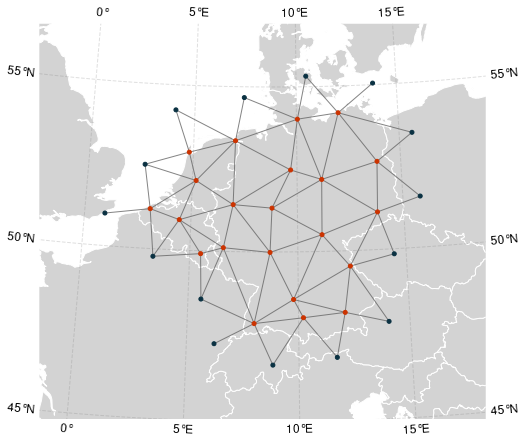

In [229]:
fig, ax = plt.subplots(figsize=(8,8), subplot_kw = {'projection' : crs})

f = ShapelyFeature(countries.geometry, ccrs.PlateCarree(), edgecolor='white')
ax.add_feature(f, facecolor=c_countries, zorder=0)

G = delaunay_b.to_undirected()
boundary_edges = [(u[0], v[0]) for u, v in it.combinations(list(G.nodes(data=True)), 2) if u[1]['boundary'] and v[1]['boundary']]
G.remove_edges_from(boundary_edges)

coord_df = gpd.GeoDataFrame(dict(radar = voronoi_b.radar, 
                             geometry = [geometry.Point((row.lon, row.lat)) for i, row in voronoi_b.iterrows()]), 
                            crs='epsg:4326').to_crs(crs.proj4_init)
pos = {ridx: (coord_df.query(f'radar == "{name}"').geometry.iloc[0].x, coord_df.query(f'radar == "{name}"').geometry.iloc[0].y) for 
       (ridx, name) in nx.get_node_attributes(delaunay_b, 'radar').items()}

node_colors = [c_boundary_light if 'boundary' in n_data['radar'] 
               else c_radar_loc for n, n_data in delaunay_b.nodes(data=True)]

nx.draw(G, pos=pos, with_labels=False, node_size=1, width=1, ax=ax, 
        edge_color=(.4, .4, .4, .8))

gplt.pointplot(radars, ax=ax, extent=extent, zorder=3, color=c_radar_loc, s=4)
gplt.pointplot(radars_b[voronoi_b.query('boundary == 1').index], ax=ax, extent=extent, zorder=3, color=c_boundary_light, s=4)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                 linewidth=1, color='gray', alpha=0.25, linestyle='--')
gl.xlocator = xspacing
gl.ylocator = yspacing

fig.savefig(osp.join(target_dir, 'delaunay_triangulation.png'), bbox_inches='tight', dpi=dpi)